import sys, importlib
importlib.reload(sys.modules['classic_CV_predict'])

In [1]:
import sys
sys.path.insert(0, "..")

from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies, create_it_matrix
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import os
import pdb
import seaborn as sns

## A) ALL_VARS, T_UNIT = 5

In [2]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\old\\'

daily_input = pd.read_csv(path+'SAN_BENIGNO_ORCO_2002_2019.csv', index_col=0, parse_dates=True)

daily_input_stat = spatial_stats_daily_input(daily_input)

t_unit=5


#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-1.5, 1.5, 10)
epsilon_range=np.logspace(-5, -2, 5)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[72]
t_length=t_range[0]
n_splits=5
test_size=365

Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"



C3=1.467799267622069
eps3=0.0017782794100389228


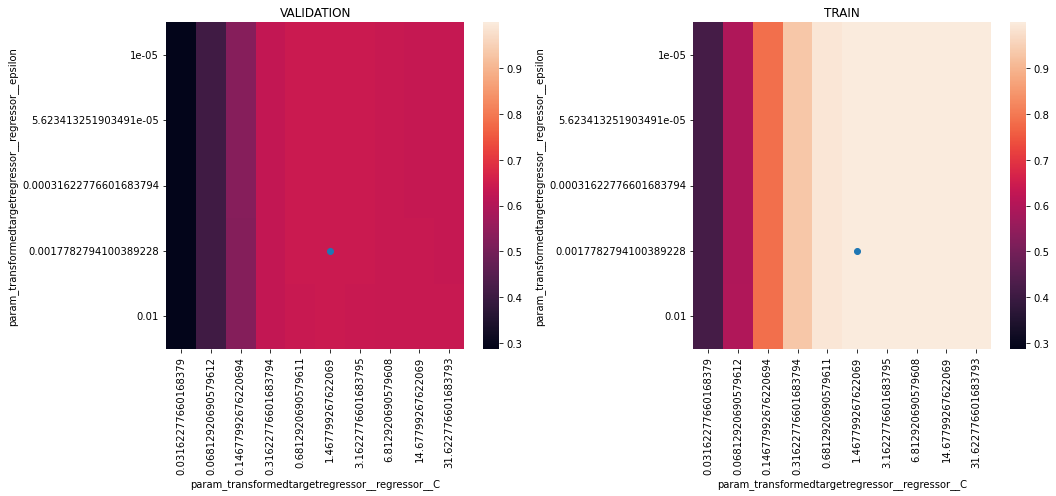

In [3]:
C, eps = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C3={C}')
print(f'eps3={eps}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [4]:
radius_for_ensemble = 1
predictions = nested_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

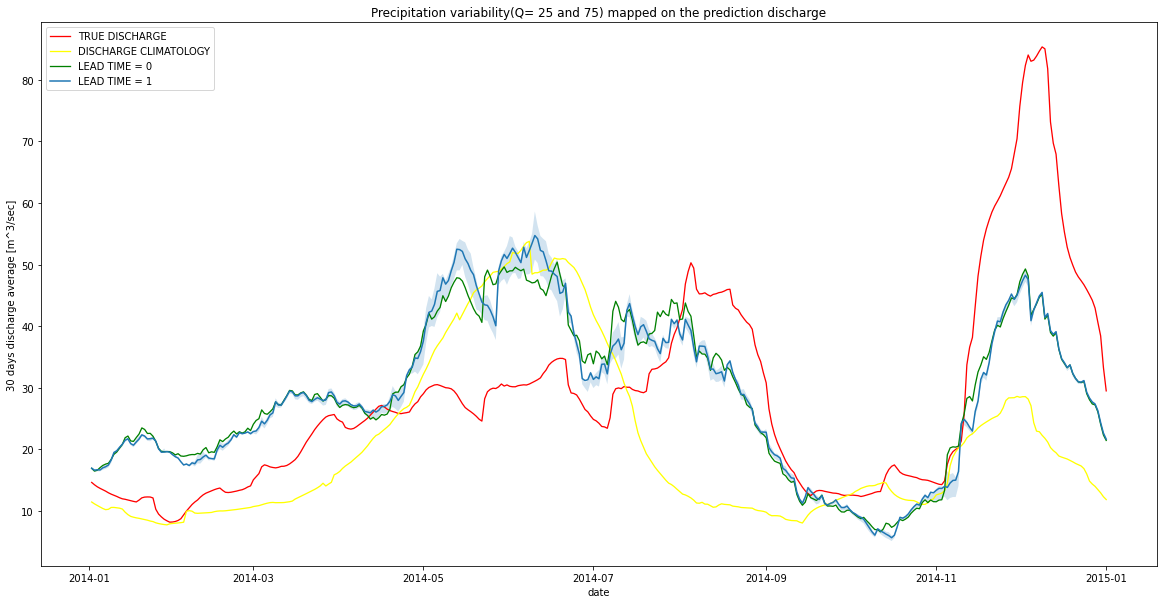

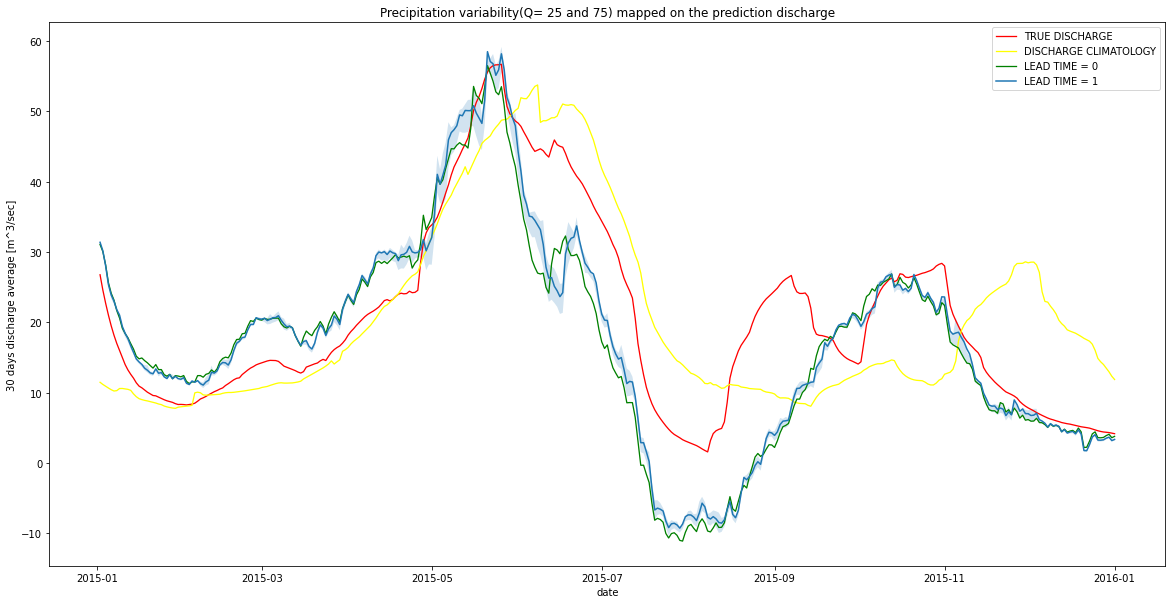

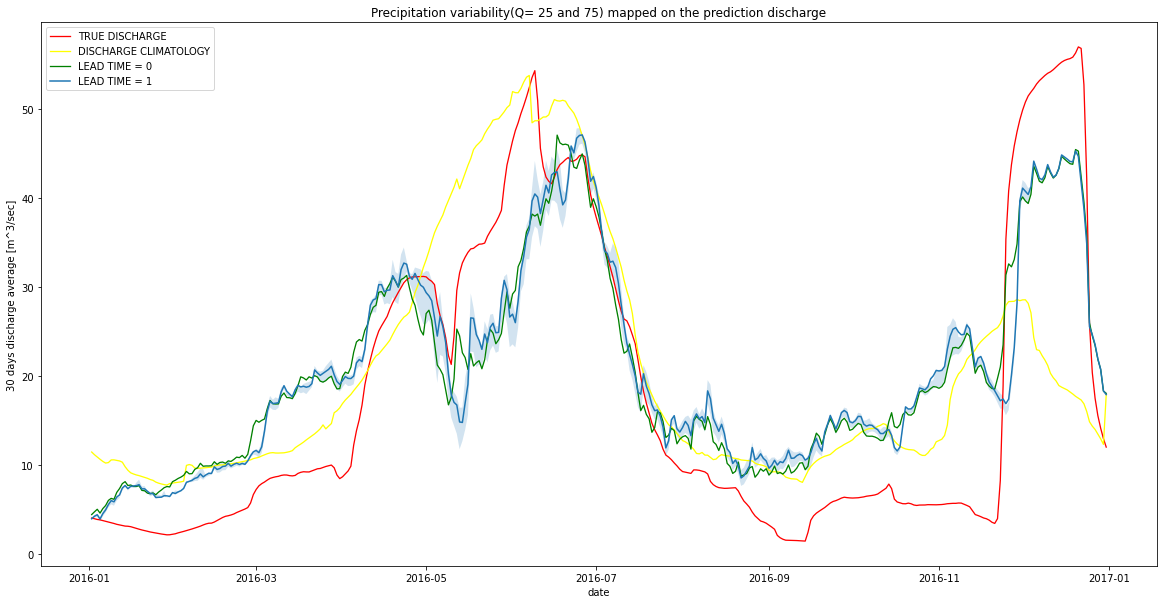

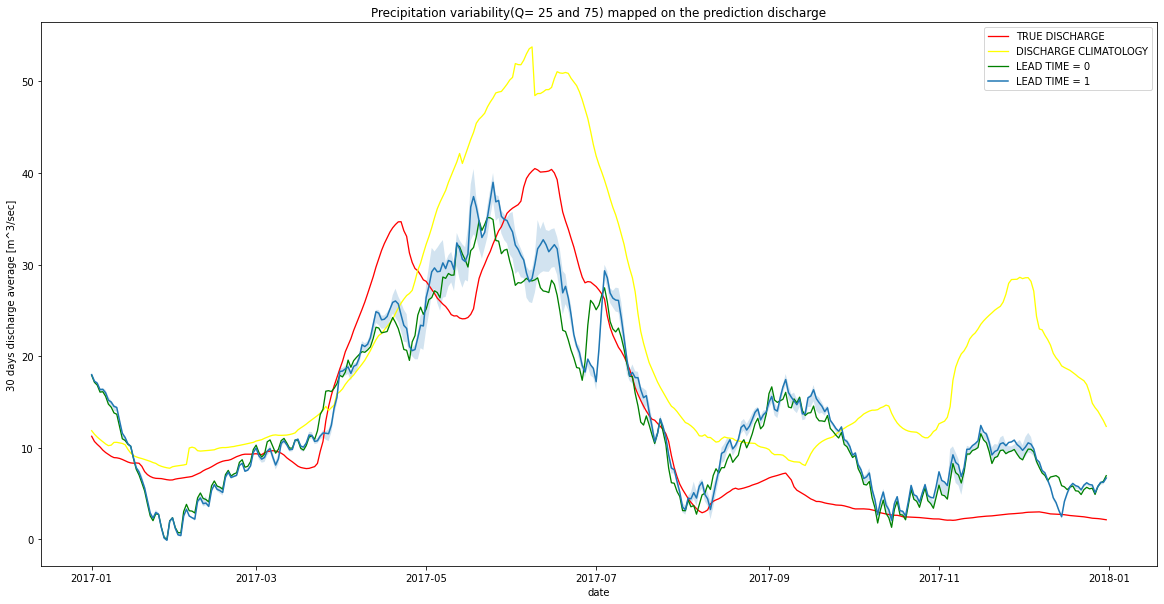

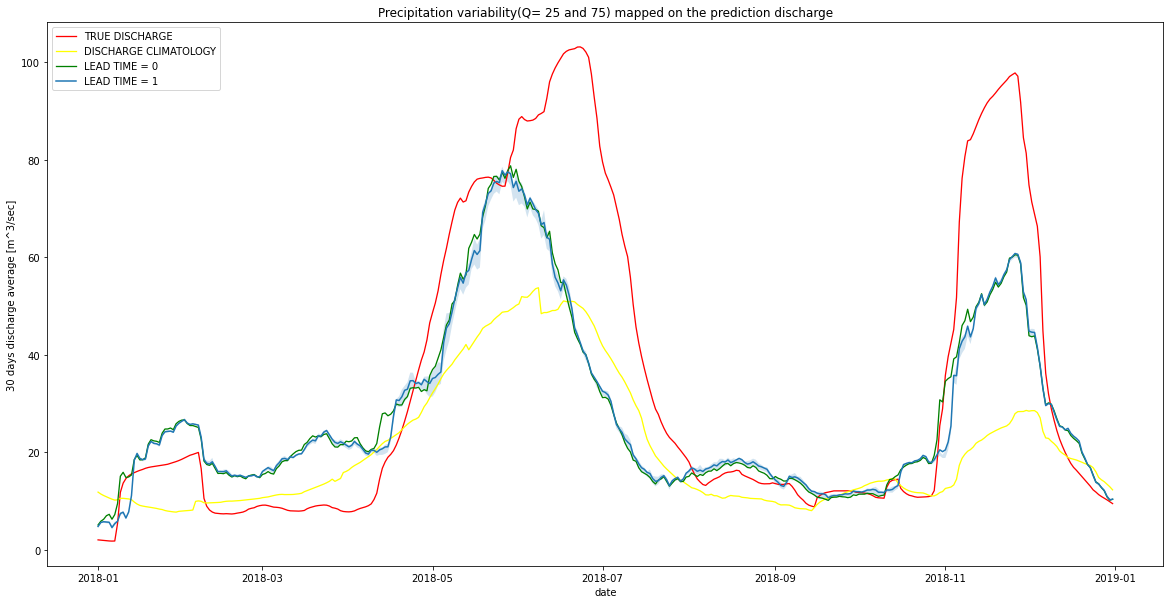

In [5]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions)

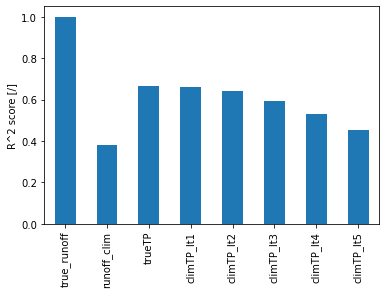

In [6]:
r2_A= evaluate_prediction(predictions)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [7]:
predictions_for_clim = classic_CV_SVR_predict(daily_input_stat, C, eps, t_length,t_unit, n_splits)

In [8]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


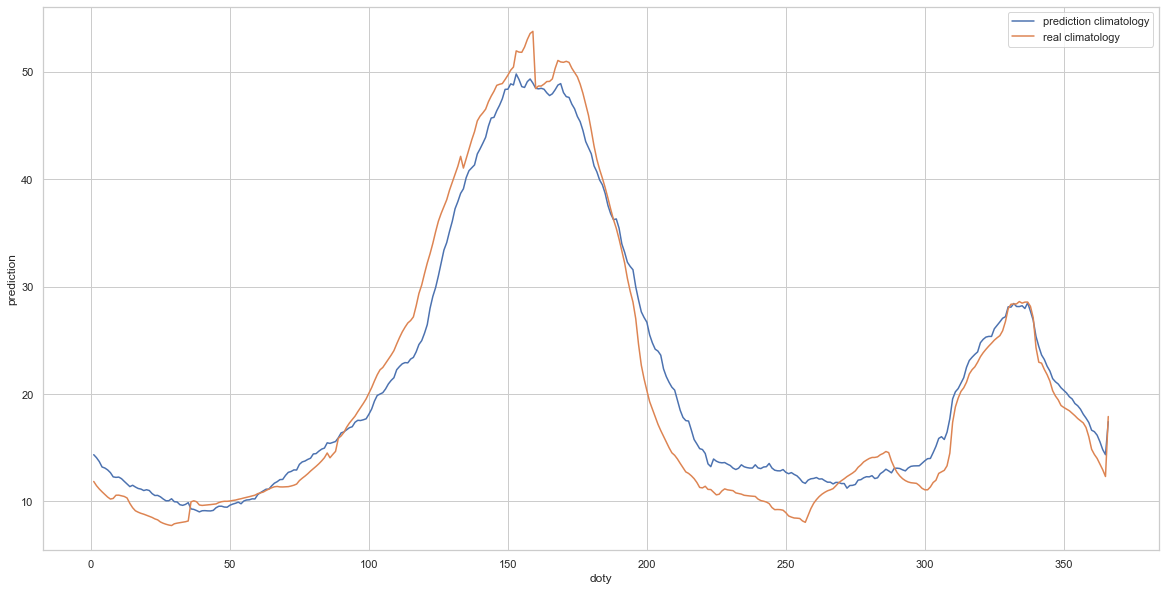

In [9]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

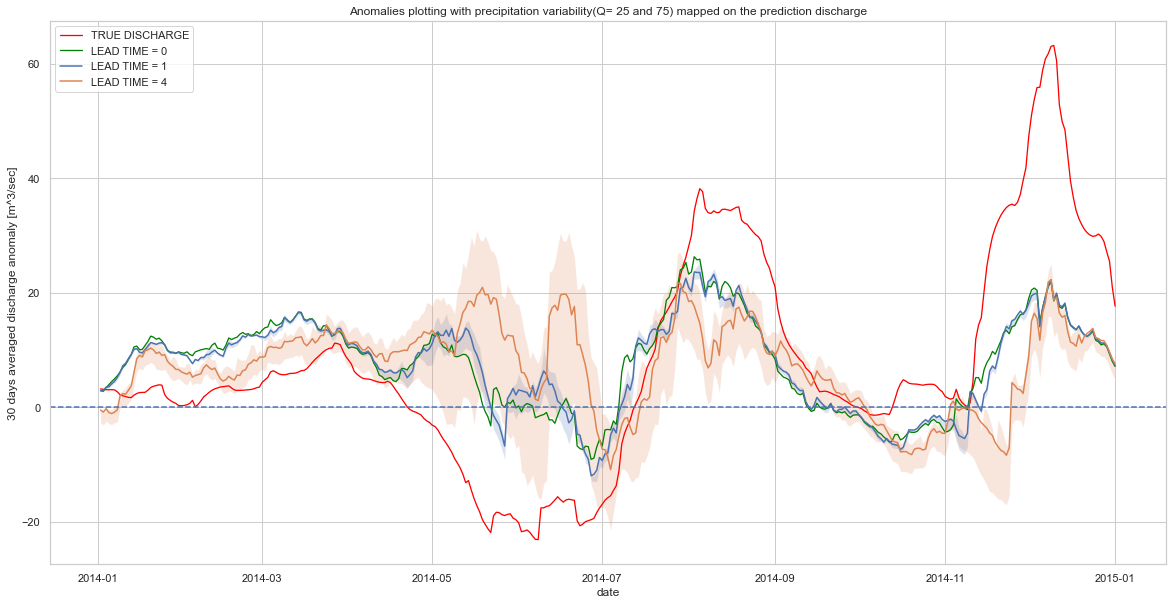

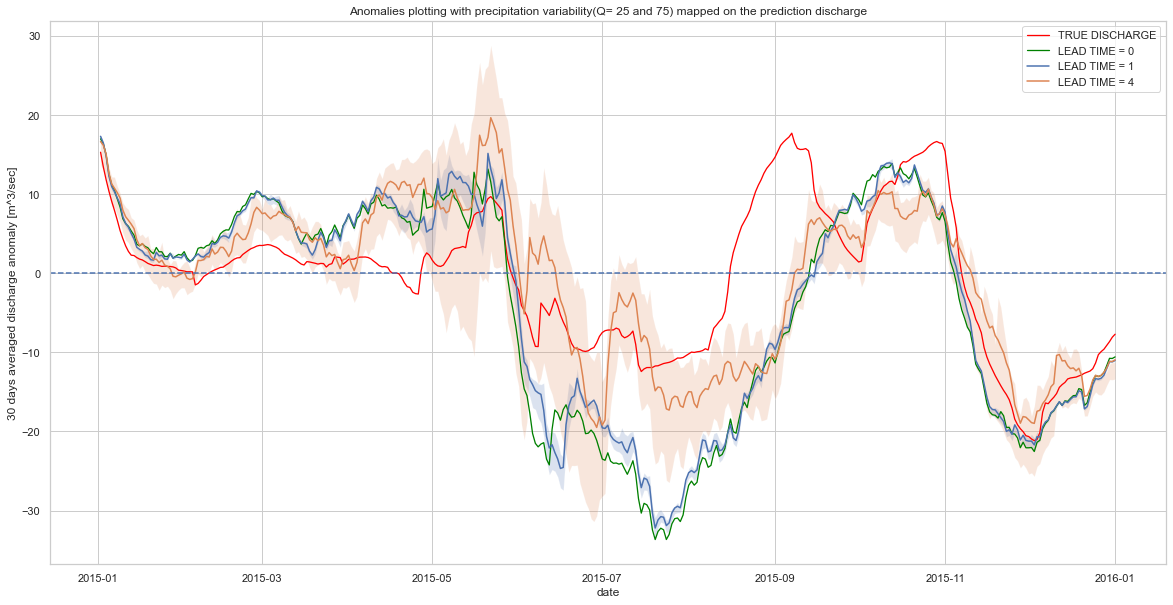

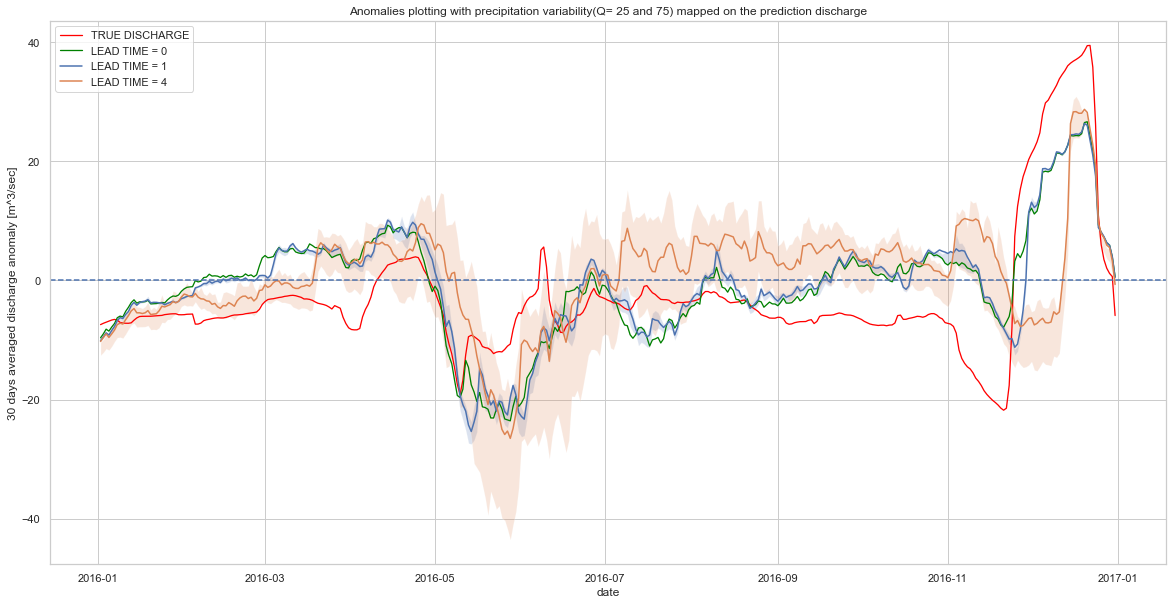

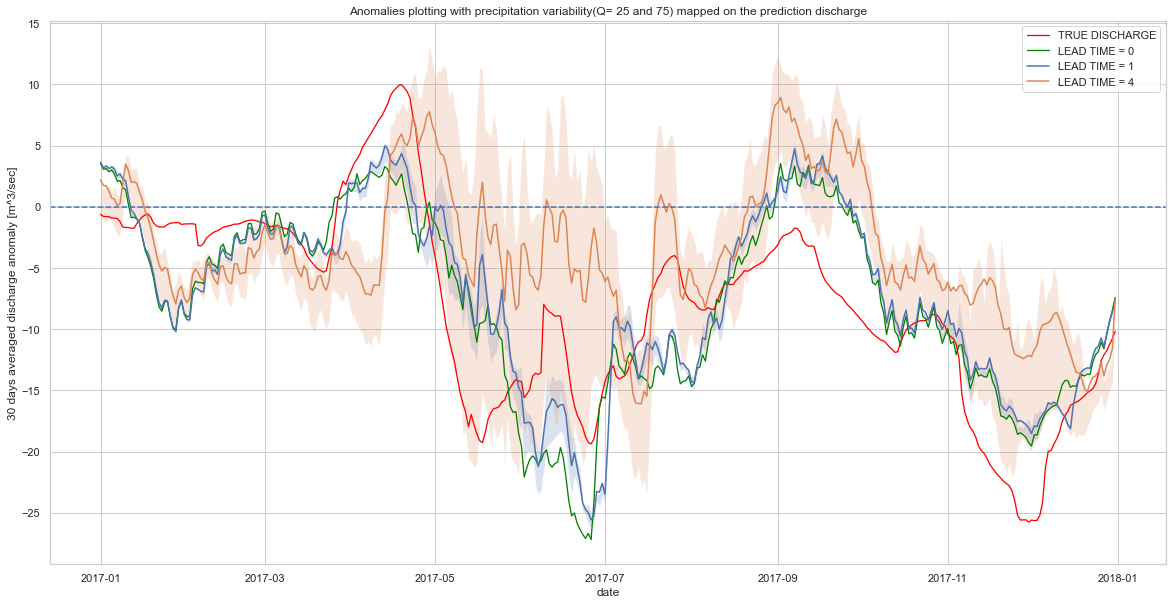

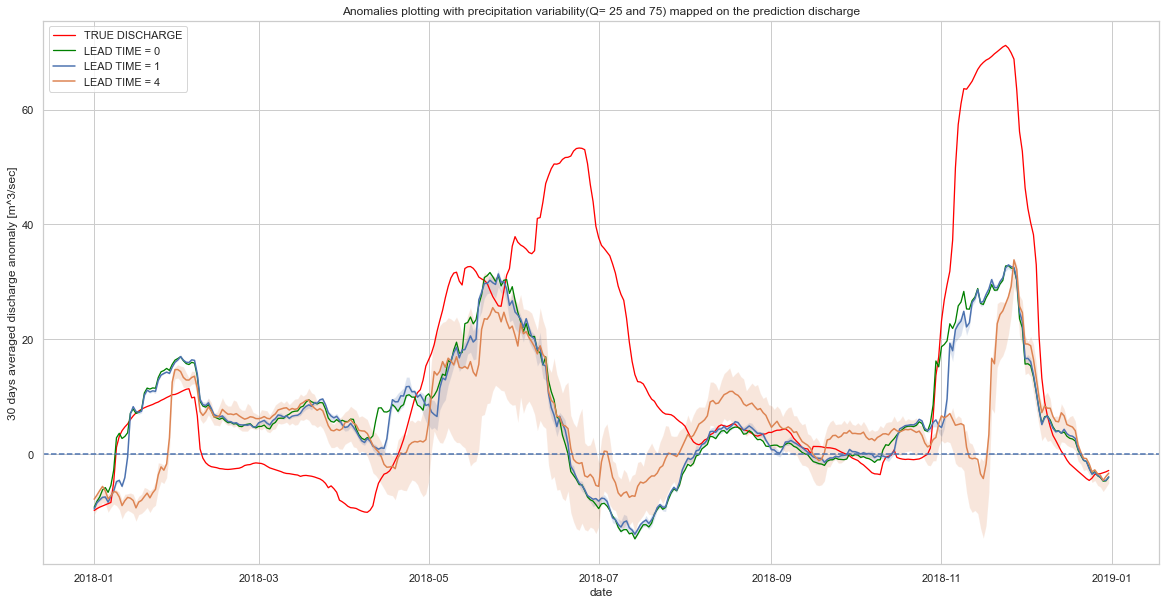

In [10]:
a=compute_anomalies(climatologies, predictions)
a['split']=predictions.split

plot_anomalies(a)

## B) NO_SNOW, T_UNIT = 5

In [11]:
daily_input_stat2 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='S'])

In [12]:
#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(1.5, -1, 5)
epsilon_range=np.logspace(-2, -1, 5)
#n_range = [17, 50, 200]
components_range = [5*4*36]
#do not enlarge t_range for now
t_range=[36]
t_length=t_range[0]
n_splits=5
test_size=365

Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"



C2=0.4216965034285822
eps2=0.01


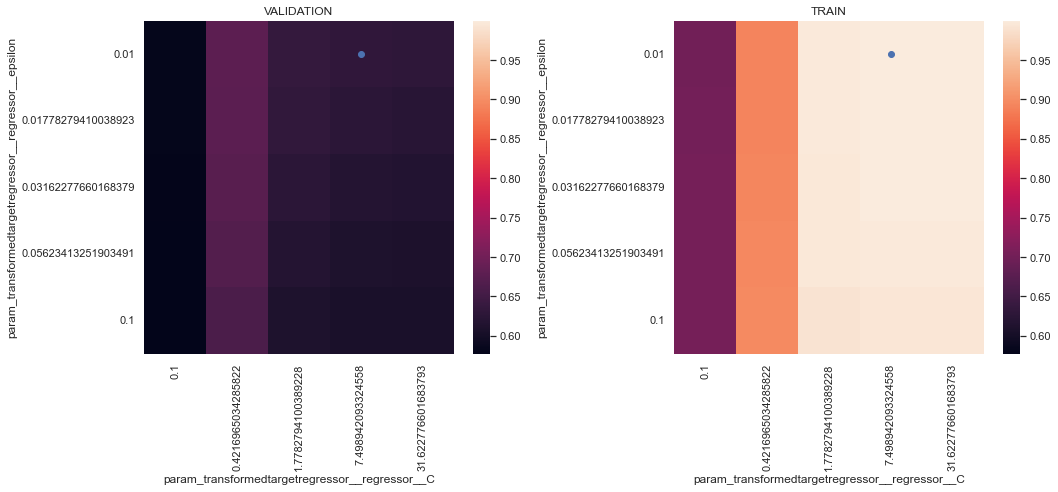

In [13]:
C2, eps2 = SVR_nested_CV_gridsearch(daily_input_stat2, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C2={C2}')
print(f'eps2={eps2}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [14]:
radius_for_ensemble = 1
predictions2 = nested_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

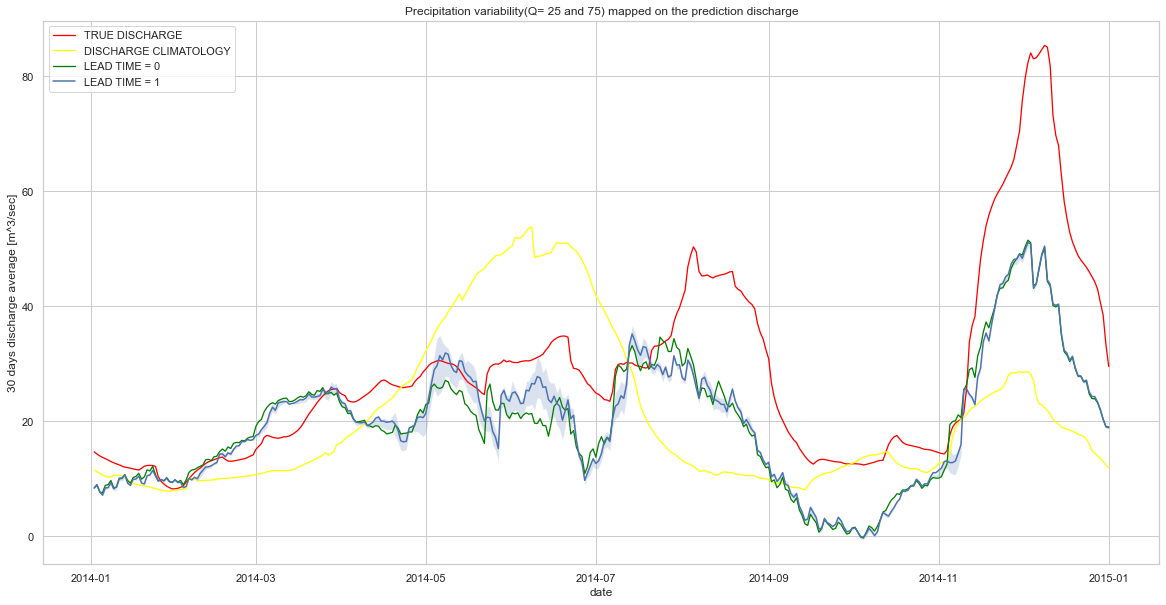

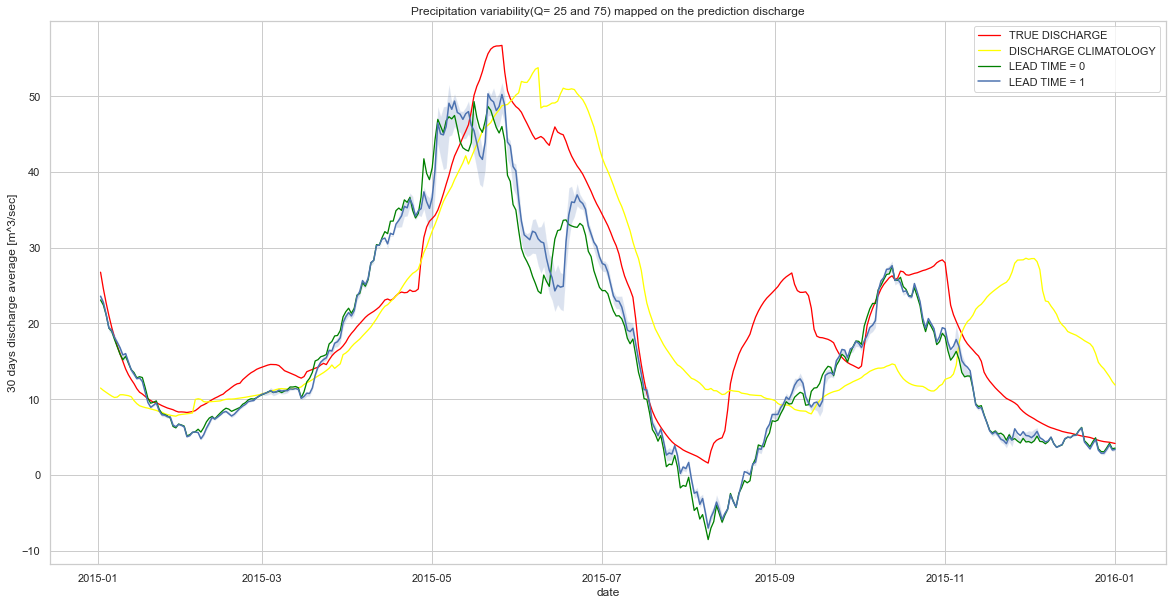

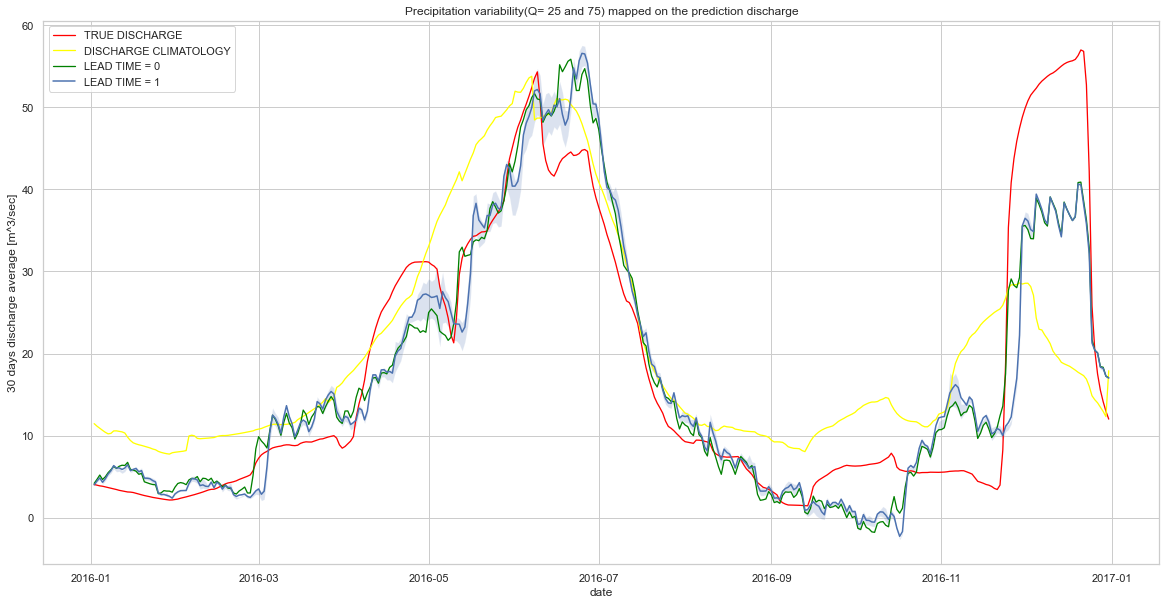

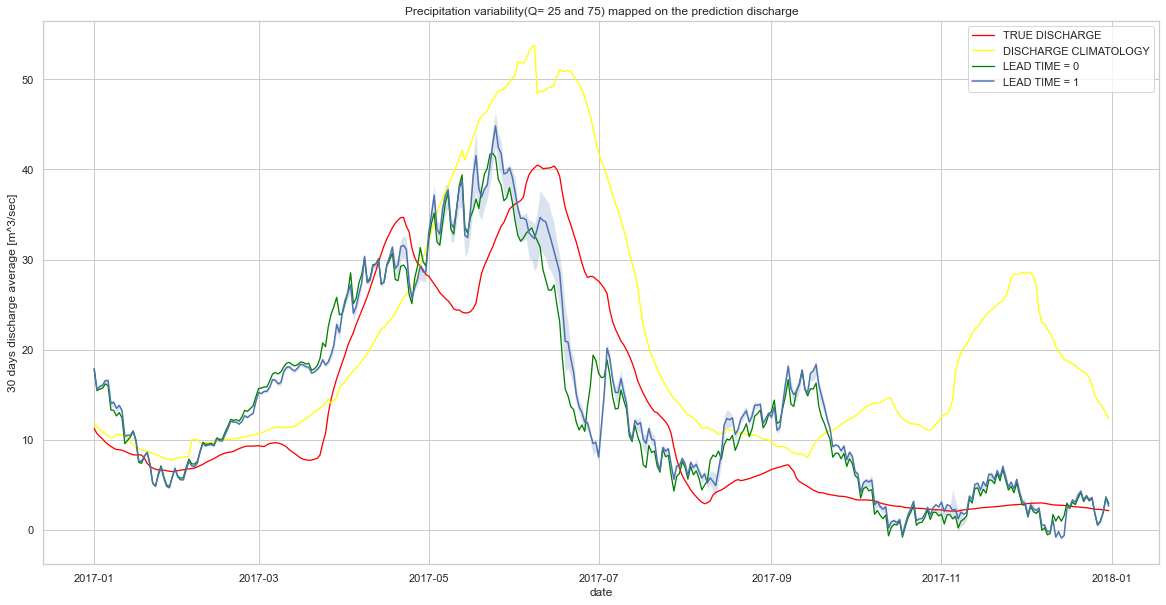

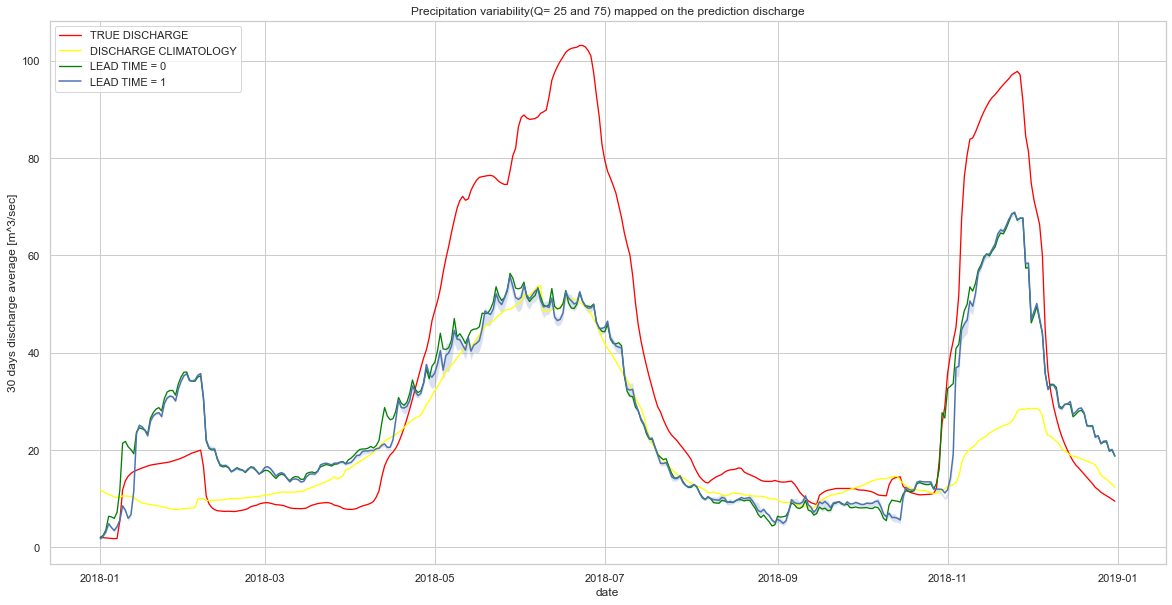

In [15]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions2)

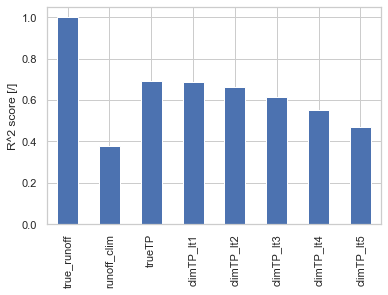

In [16]:
r2_B= evaluate_prediction(predictions2)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [17]:
predictions_for_clim2 = classic_CV_SVR_predict(daily_input_stat2, C2, eps2, t_length, t_unit, n_splits)

In [18]:
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


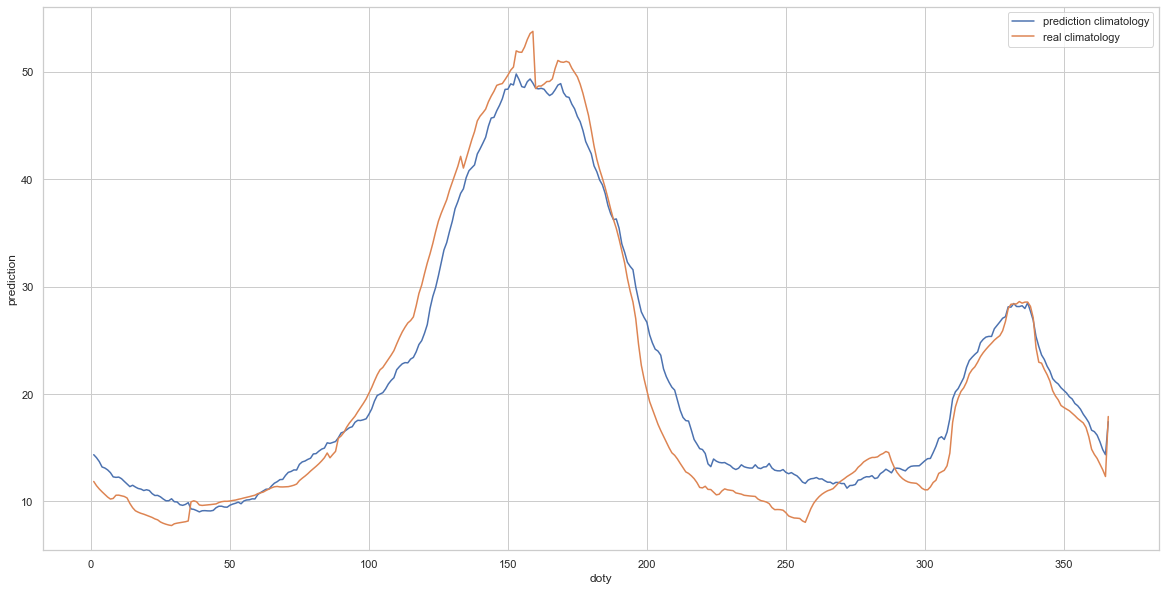

In [19]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

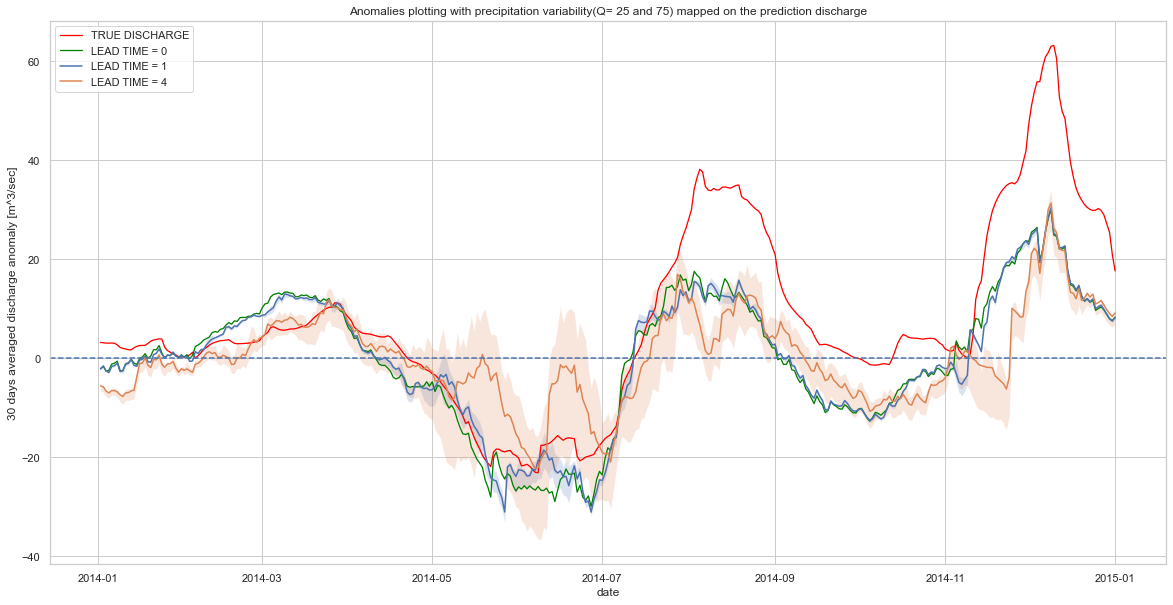

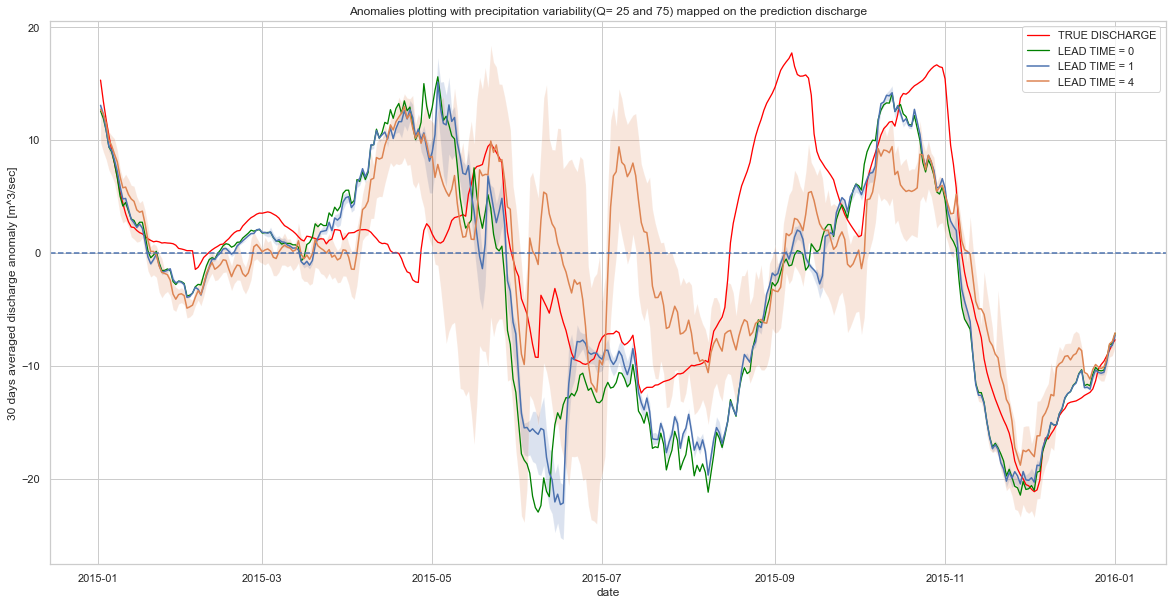

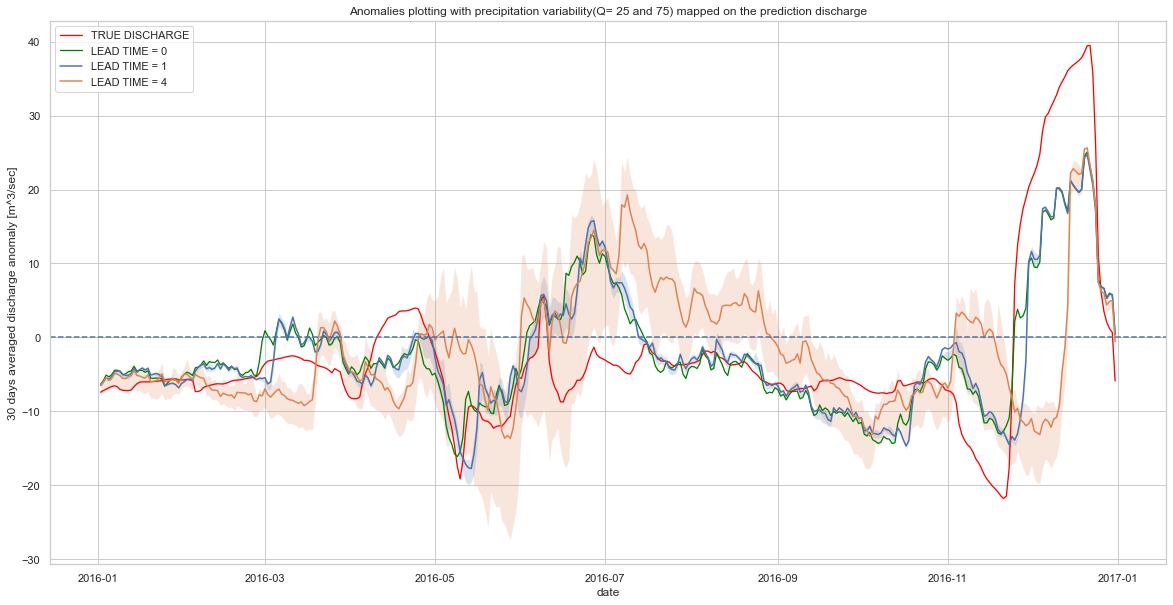

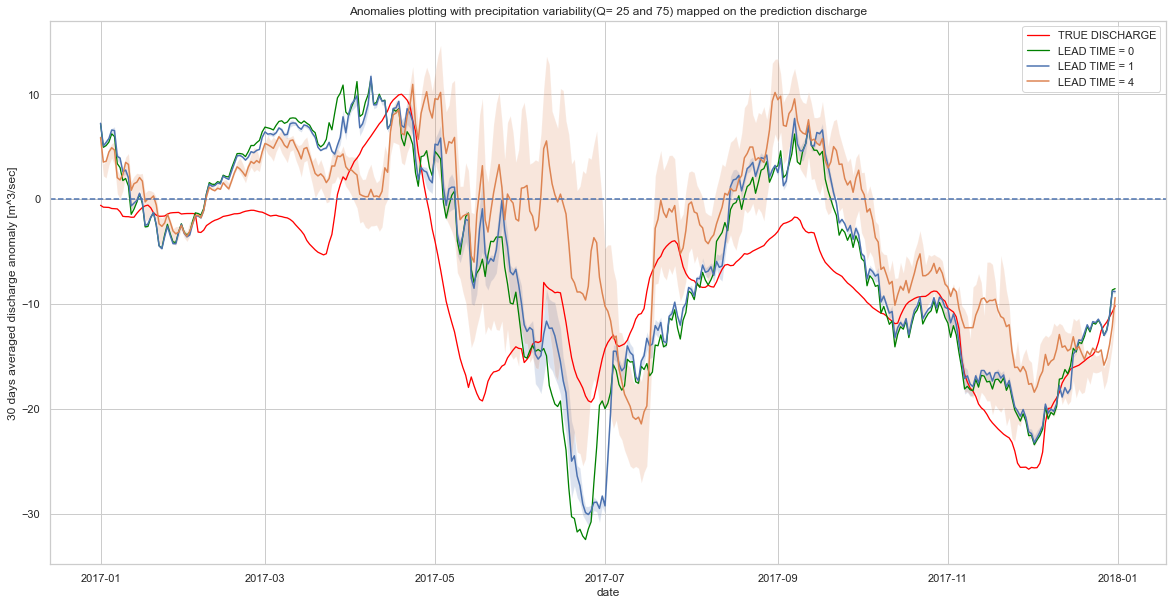

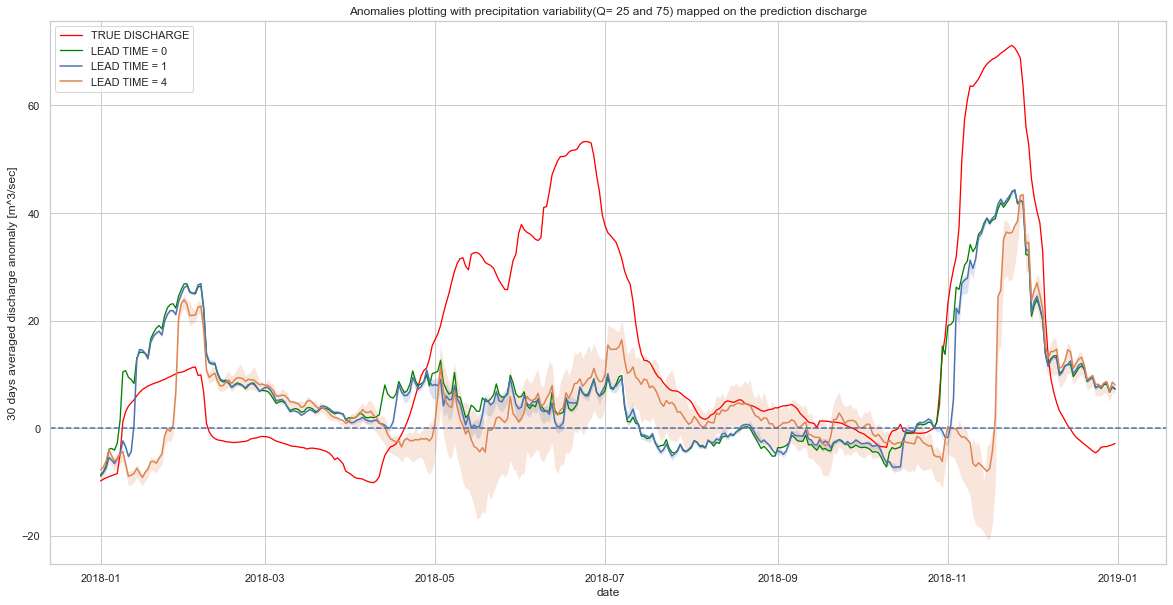

In [20]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split

plot_anomalies(a2)

## C) NO_EVAP, T_UNIT = 5

In [21]:
daily_input_stat3 = daily_input_stat.drop(columns=[c for c in daily_input_stat.columns if c[0]=='E'])

t_unit=10

Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"


Fitting 1 folds for each of 25 candidates, totalling 25 fits


C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\sklearn\compose\_target.py:152: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn("The provided functions or transformer are"



C3=1.7782794100389228
eps3=0.01


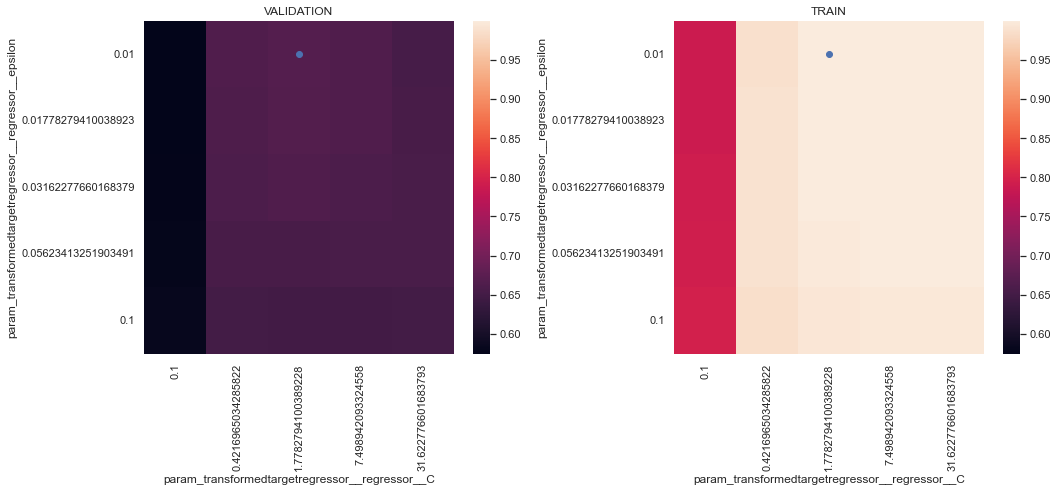

In [22]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat3, C_range, epsilon_range, t_range, t_unit, n_splits, test_size)
print(f'C3={C3}')
print(f'eps3={eps3}')

In [23]:
C3=0.4216965034285822
eps3=0.05623413251903491


### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [24]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

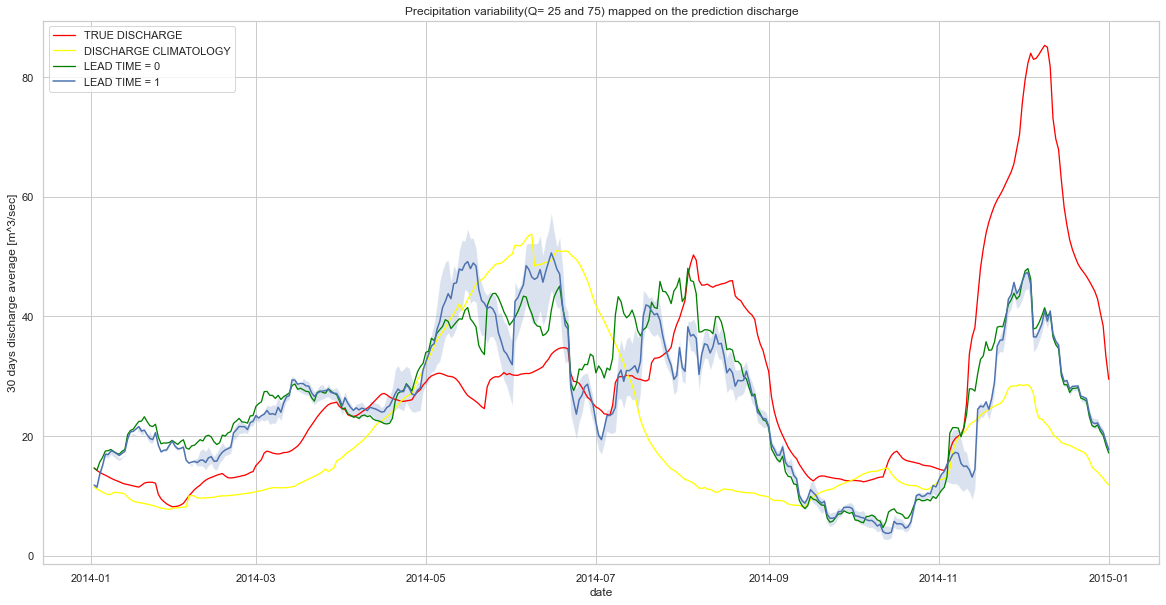

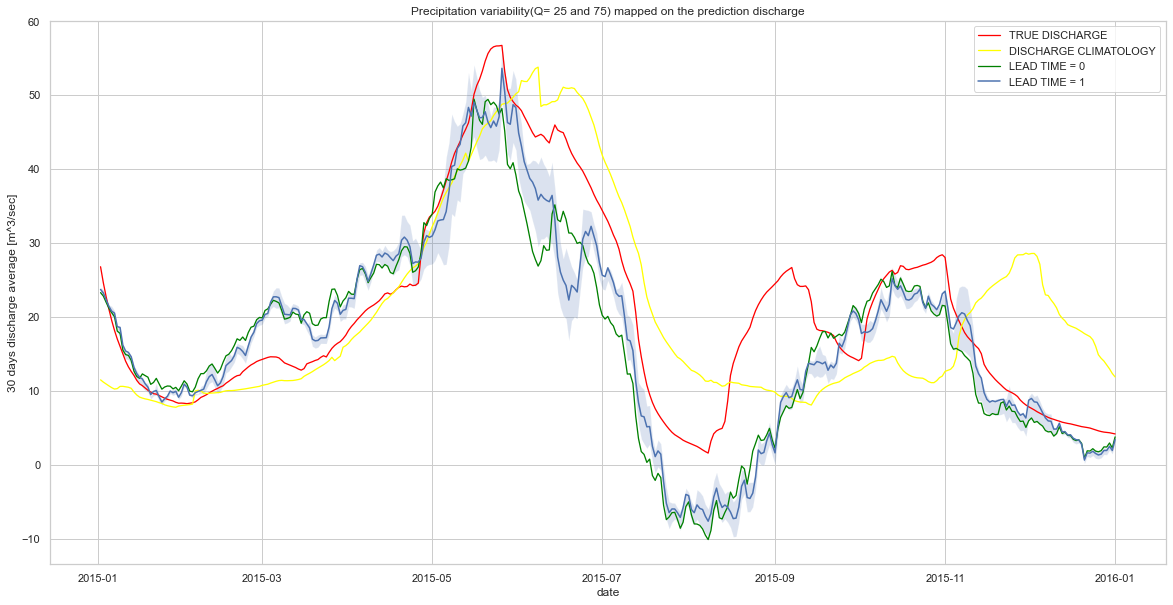

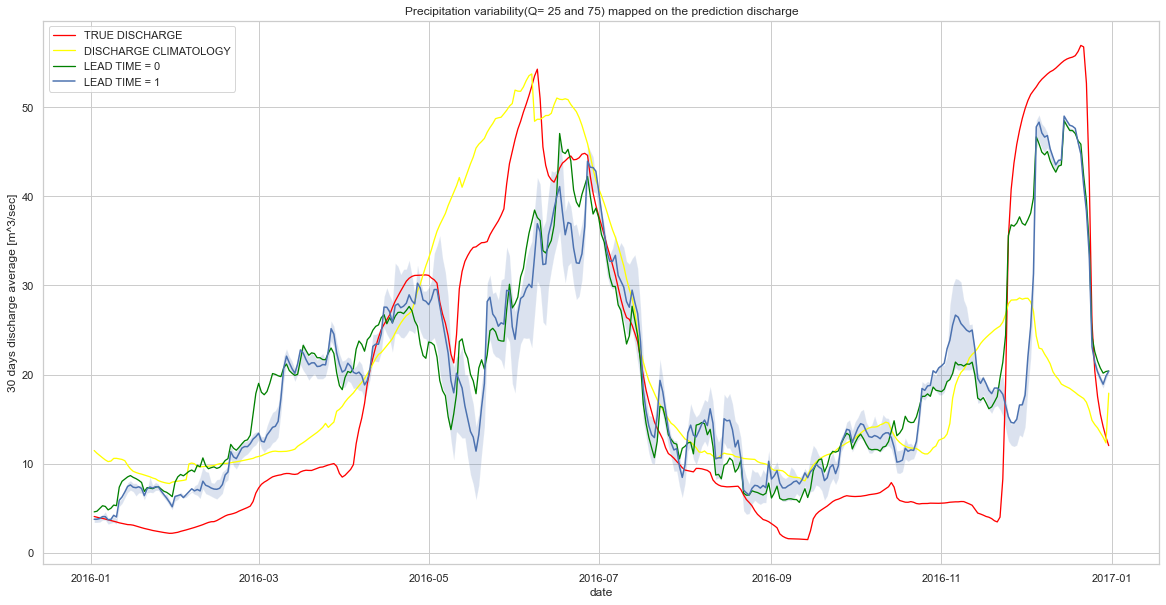

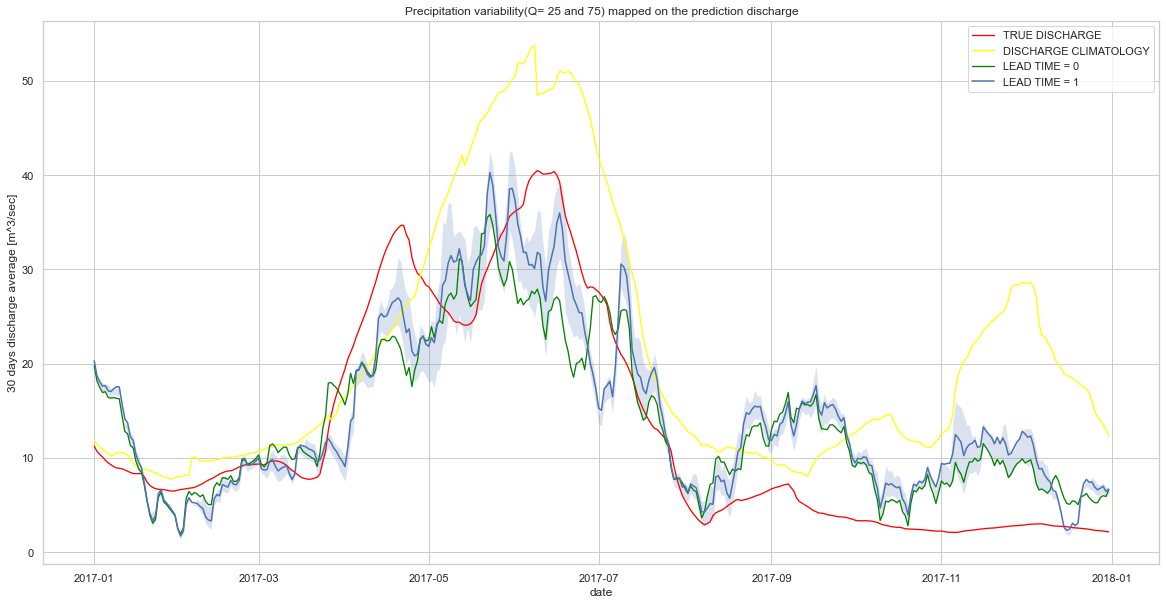

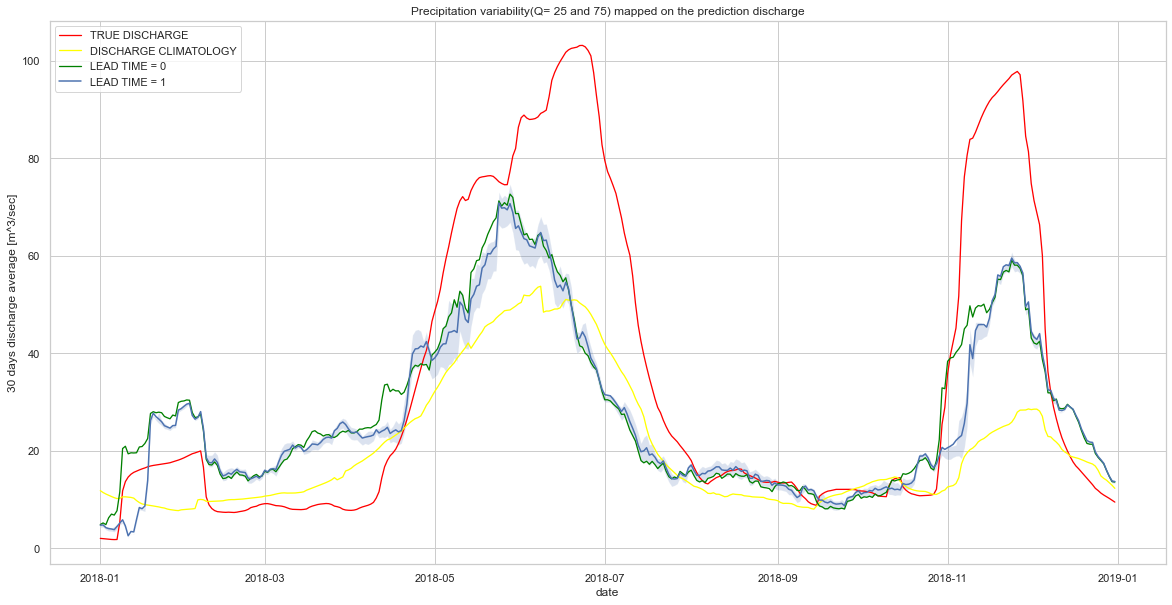

In [25]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3)

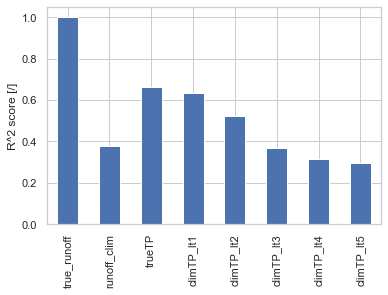

In [26]:
r2_C= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [27]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat3, C3, eps3, t_length, t_unit, n_splits)

In [28]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


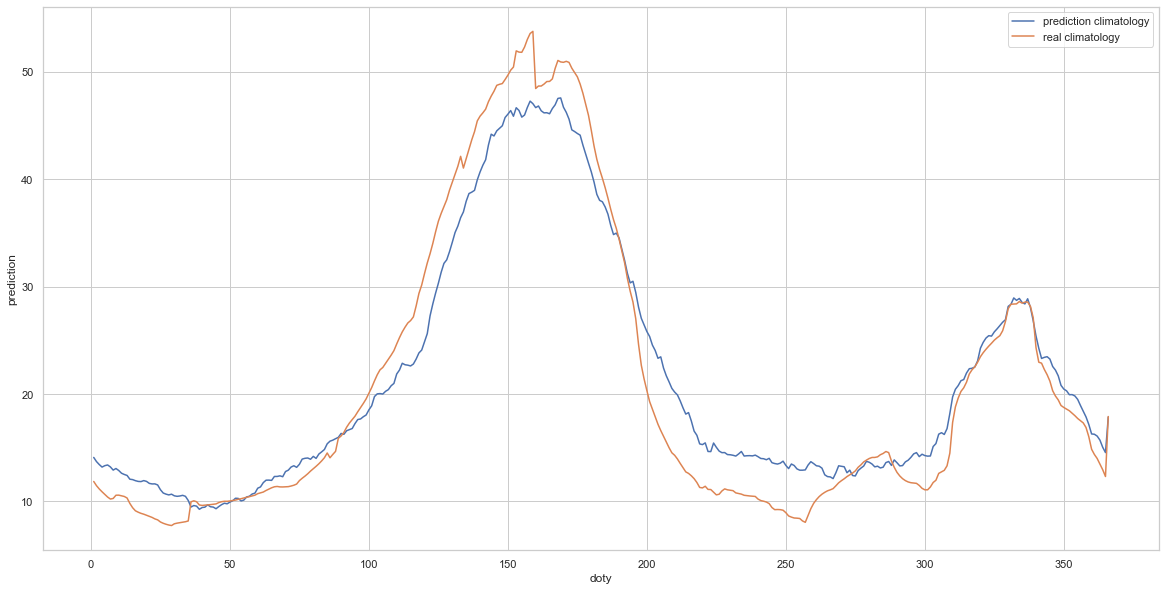

In [29]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

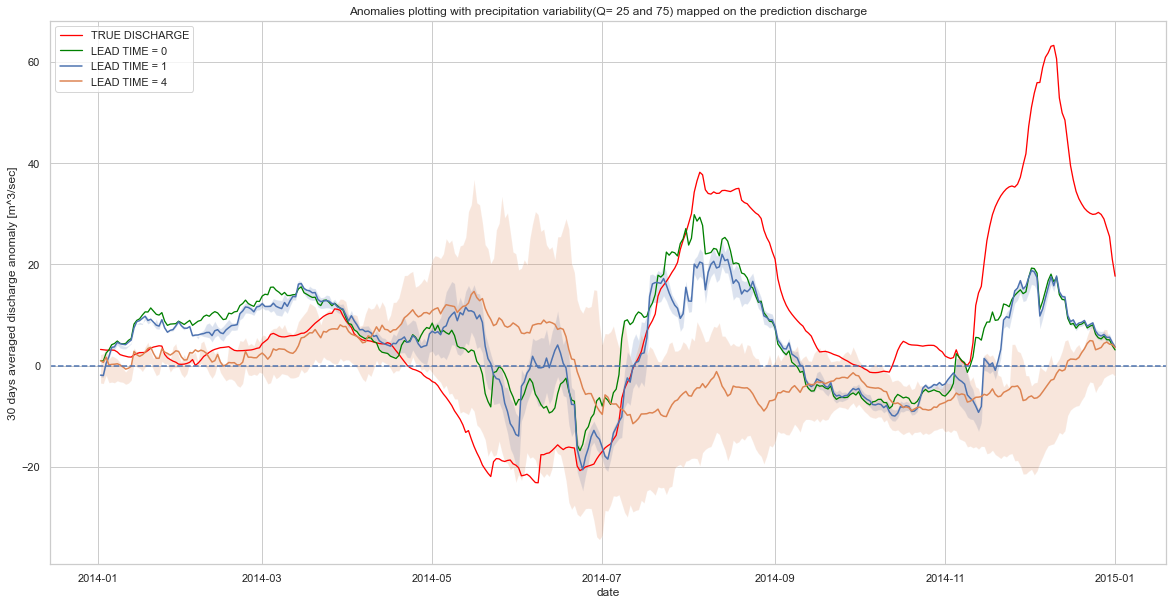

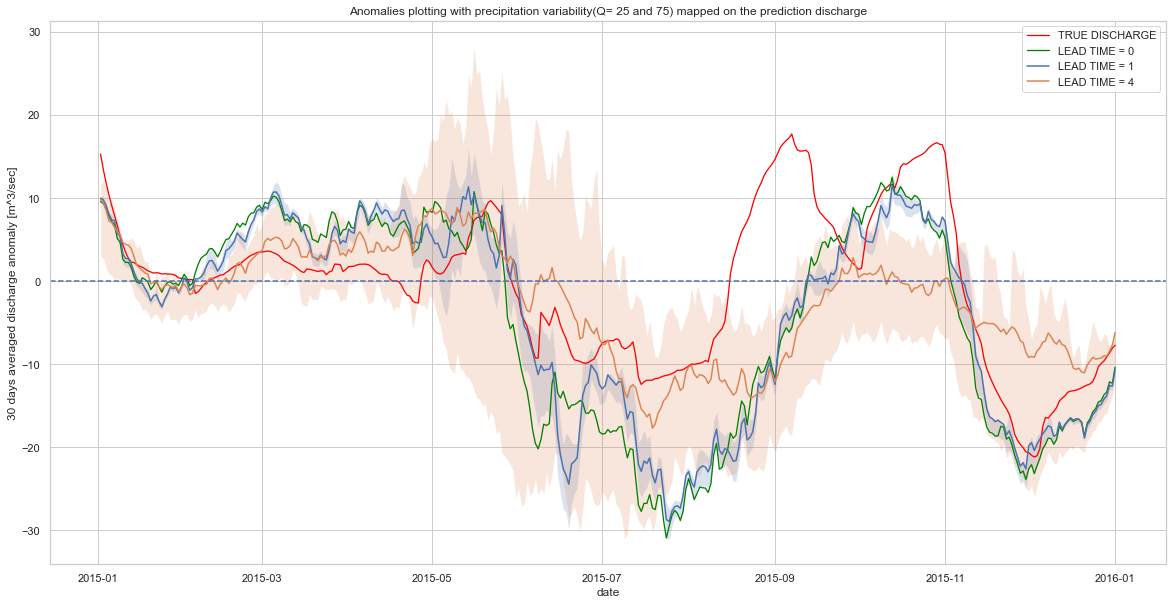

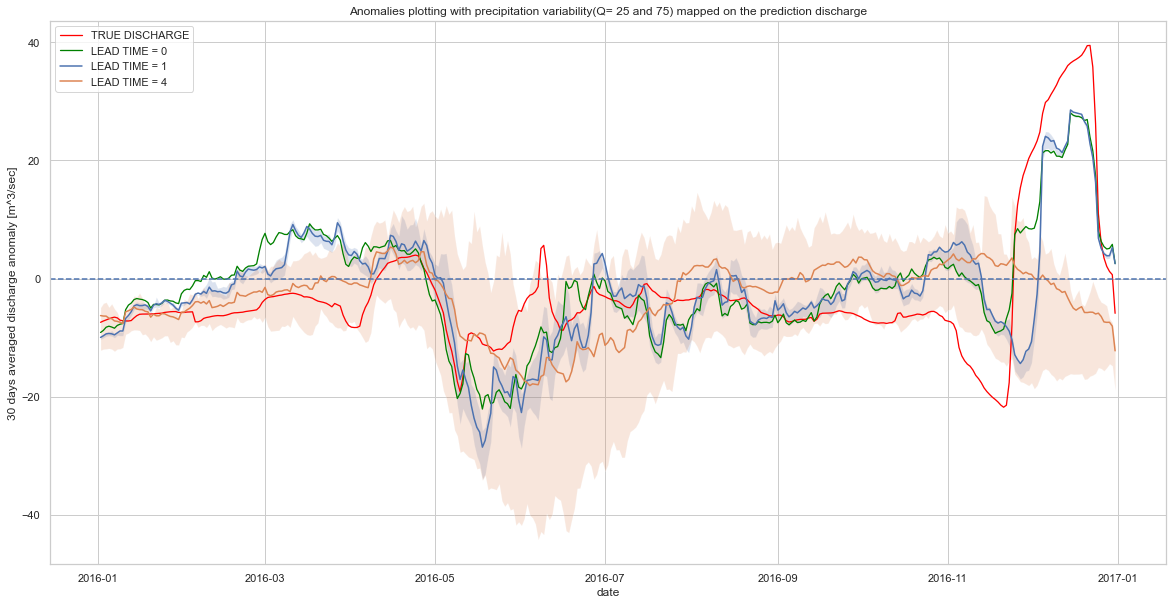

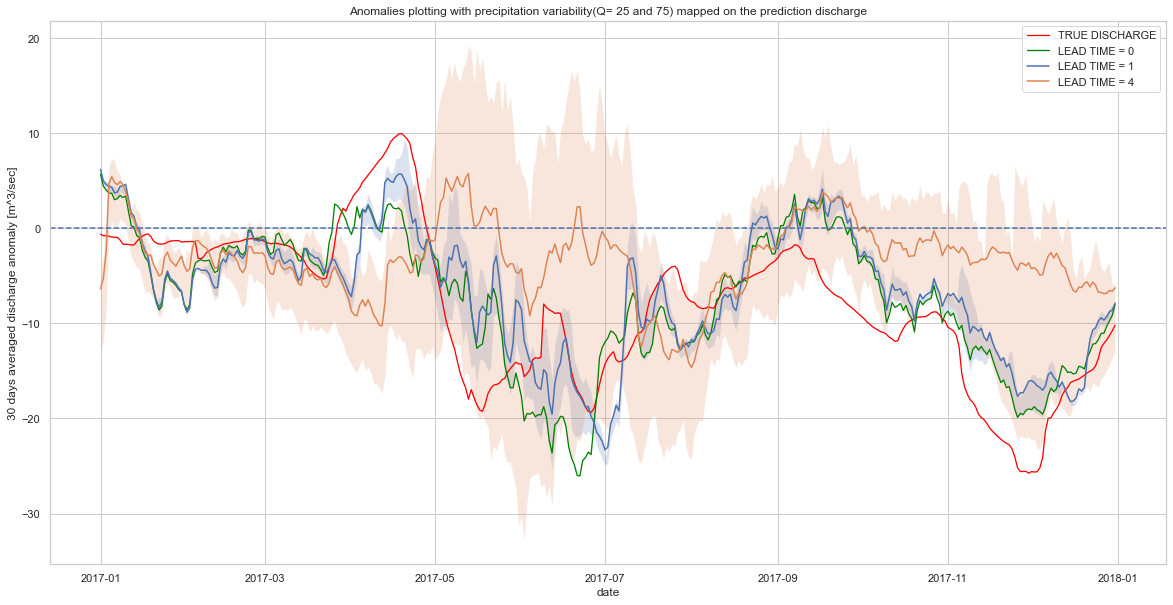

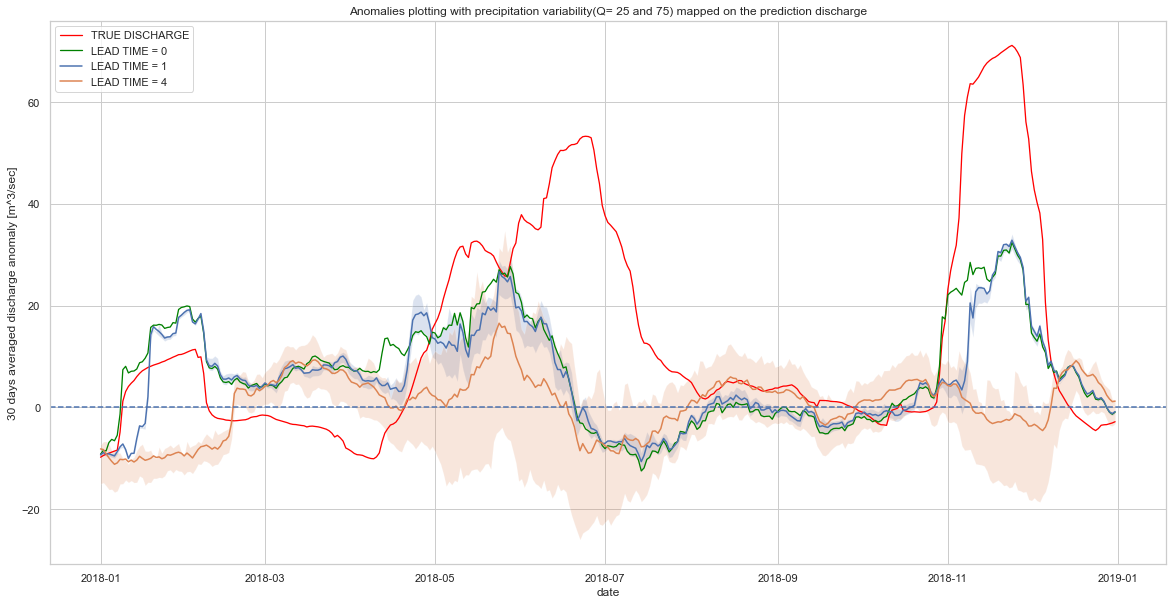

In [30]:
a3=compute_anomalies(climatologies3, predictions3)
a3['split']=predictions3.split

plot_anomalies(a3)

# COMPARE RESULTS

Text(0, 0.5, 'r^2 [/]')

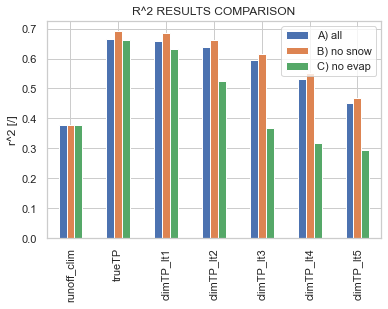

In [31]:
results = pd.concat([r2_A,r2_B,r2_C],axis=1)
results.columns=['A) all','B) no snow','C) no evap']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

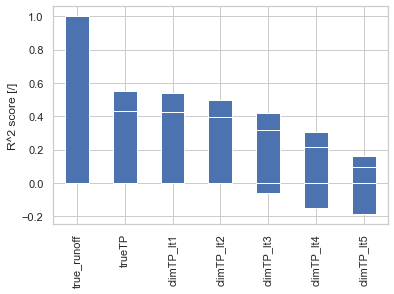

In [32]:
r2_a_C= evaluate_prediction(a3)
r2_a_B = evaluate_prediction(a2)
r2_a_A = evaluate_prediction(a)

Text(0.5, 1.0, 'R^2 RESULTS COMPARISON')

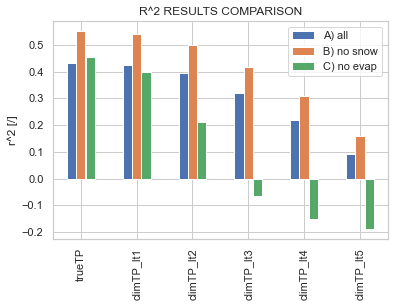

In [33]:
results_a = pd.concat([r2_a_A,r2_a_B,r2_a_C],axis=1)
results_a.columns=['A) all','B) no snow','C) no evap']
results_a.iloc[1:].plot.bar()
plt.ylabel('r^2 [/]')
plt.title('R^2 RESULTS COMPARISON')


In [34]:
arrays = [[np.array(np.repeat((t_unit),8),dtype=object),np.array(results.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results.index=index

results


A) all  B) no snow  C) no evap
t_unit lt                                           
10     true_runoff  1.000000    1.000000    1.000000
       runoff_clim  0.378261    0.378261    0.378261
       trueTP       0.663768    0.691152    0.662108
       climTP_lt1   0.659923    0.686368    0.631662
       climTP_lt2   0.639379    0.662793    0.525378
       climTP_lt3   0.593427    0.615425    0.366991
       climTP_lt4   0.530703    0.552872    0.317667
       climTP_lt5   0.452829    0.468052    0.295010

In [35]:
arrays = [[np.array(np.repeat((t_unit),7),dtype=object),np.array(results_a.index)]]
tup=np.concatenate(arrays)
index = pd.MultiIndex.from_arrays(tup, names=["t_unit" , "lt"])

results_a.index=index

results_a

A) all  B) no snow  C) no evap
t_unit lt                                           
10     true_runoff  1.000000    1.000000    1.000000
       trueTP       0.433776    0.552230    0.456413
       climTP_lt1   0.425597    0.542352    0.397409
       climTP_lt2   0.393478    0.499040    0.209916
       climTP_lt3   0.319095    0.416941   -0.063585
       climTP_lt4   0.217707    0.307566   -0.149505
       climTP_lt5   0.092581    0.160238   -0.187373

In [36]:
results.to_csv('results/SAN_BENIGNO__5.csv')
results_a.to_csv('results/SAN_BENIGNO__5_a.csv')